# Lab 2
Reporter: Ksenofontov Grigorii

Task: Visualize posterior covariance matrix for each extremum of mult-extremal classification model. Model: 1-layer neural network. Dataset: on your choice (synthetic dataset is allowed). Use normal distribution with diagonal covariance prior. For posterior distribution use Laplace approximation.

## Theory

We know likelihood of MLP and prior, so we can calculate posterior:<br>
$p(y, \omega|X, A) = p(y| \omega, X)p(\omega|A) = \prod_{j=1}^{n} \sigma(y_{j}w^{T} x_{j})$ $\mathcal{N} (0,A^{-1})$, where $A = diag(\alpha)$, $n$ - number of feauters <br>

To evaluate covariance matrix we maximize evidace using Laplace approximation: <br>
$A^{*} = \arg \max_{A} \int p(y|X,\omega) p(\omega|A) d\omega$ <br>
Let $S(\omega) = p(y|X,\omega) p(\omega|A)$, so, <br> $\log S(\omega) = \sum_{j=1}^{n} \log\sigma(y_{j}w^{T} x_{j}) + \log\mathcal{N} (0,A^{-1})$ <br> Then using using Laplace approximation for linear model case:<br>
$ \log S(\omega) \sim \log S(\omega^{MAP}) + \frac{n}{2}\log(2\pi) + \frac{1}{2}\log\mathbf{\det H^{-1}}$, where $\mathbf{H} = \nabla \nabla \log S(\omega^{MAP}) $ <br><br>
Fianlly, we can estimate $A^*$: <br>
$A^{*} = \arg \max_{A} \left( \log S(\omega^{MAP}) + \frac{n}{2}\log(2\pi) + \frac{1}{2}\log\mathbf{\det H^{-1}} \right)$ <br><br>

To find $\omega^{MAP}$ we need to minimize $S(\omega)$:<br>
$\omega^{MAP} = \arg \min_{\omega} \log S(\omega)$

In [ ]:
import numpy as np

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

import jax.numpy as jnp
from jax import nn, random, grad, hessian
from jax.scipy import stats as sp
from jax.scipy import linalg

import matplotlib.pyplot as plt
from tqdm import tqdm

### Dataset


In [ ]:
X, Y = load_digits(return_X_y=True)
X = np.append(X, np.ones((X.shape[0], 1)), axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=42)

X_train, X_test, Y_train, Y_test = jnp.array(X_train, dtype=jnp.float32),\
                                   jnp.array(X_test, dtype=jnp.float32),\
                                   jnp.array(Y_train, dtype=jnp.float32),\
                                   jnp.array(Y_test, dtype=jnp.float32),\

samples, features = X_train.shape

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1437, 65), (360, 65), (1437,), (360,))

In [ ]:
samples, features

(1437, 65)

In [ ]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std
X_train = jnp.nan_to_num(X_train, 0.)
X_test = jnp.nan_to_num(X_test, 0.)

### $\omega^{MAP}$ evaluation


In [ ]:
def initialize_weights(layer_size, seed, alphas=jnp.array([1] * (features))):
    A = jnp.diag(alphas)
    invA = jnp.linalg.inv(A)
    weights = random.multivariate_normal(key=seed, mean=jnp.zeros(features), cov=invA, shape=(layer_size,), dtype=jnp.float32)
    return weights


######## TEST ########

test_weights = initialize_weights(1, random.PRNGKey(42))
test_weights.shape

(1, 65)

In [ ]:
def linear_layer(weights, x, activation=lambda x: x):
    out = jnp.dot(x, weights.T)
    return activation(out)

def log_probs(weights, alphas=jnp.array([1] * (features))):
    invA = jnp.linalg.inv(jnp.diag(alphas))
    log_prob = sp.multivariate_normal.logpdf(weights.squeeze(), jnp.zeros(features),  invA)
    return log_prob
    

def criterion(weights, x, y):
    preds = linear_layer(weights, x, nn.sigmoid).squeeze()
    log_preds = jnp.log(jnp.where(preds > 0., preds, 1.))
    return - jnp.sum(y * log_preds) + log_probs(weights)

def calculate_grad(weights, x, y):
    grad_loss = grad(criterion)
    grads = grad_loss(weights, x, y)
    return grads

def train(weights, X, Y, learning_rate, epochs, verbose=True):
    losses = []
    for i in range(1, epochs + 1):
        loss = criterion(weights, X, Y)
        grads = calculate_grad(weights, X, Y)
        # Update weights
        weights -= learning_rate * grads
        losses.append(loss)

        if verbose and i % 20 == 0: ## Print loss every 20 epochs
          print(f"epoch: {i}, loss: {loss:.8f}")
    return weights, losses

epoch: 20, loss: 4241.05908203
epoch: 40, loss: 3474.59008789
epoch: 60, loss: 3281.36523438
epoch: 80, loss: 3219.92138672
epoch: 100, loss: 3195.87866211


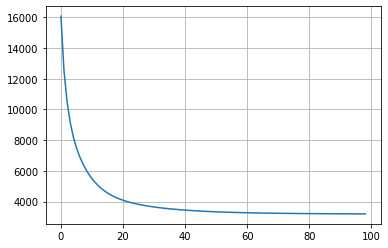

In [ ]:
seed = random.PRNGKey(42)
learning_rate = jnp.array(2e-4)
epochs = 100
layer_size = 1

weights = initialize_weights(layer_size, seed)
weights_map, losses = train(weights, X_train, Y_train, learning_rate, epochs)
plt.grid()
plt.plot(losses[1:])
plt.show()

### Laplace approximation of $A$

In [ ]:
def criterion_laplace(alphas, x, y):
    preds = linear_layer(weights_map, x, nn.sigmoid).squeeze()
    log_preds = jnp.log(jnp.where(preds > 0., preds, 1.))
    error_func = lambda weights: - jnp.sum(y * jnp.log(linear_layer(weights, x, nn.sigmoid).squeeze())) + log_probs(weights, alphas)
    hessian_computed = hessian(error_func)(weights_map).squeeze()
    return - jnp.sum(y * log_preds) + log_probs(weights_map, alphas) + features/2 * jnp.log(jnp.pi) + 0.5 * jnp.linalg.det(jnp.linalg.inv(hessian_computed))

def calculate_grad_laplace(alphas, x, y):
    grad_loss = grad(criterion_laplace)
    grads = grad_loss(alphas, x, y)
    return grads

def train_laplace(alphas, X, Y, learning_rate, epochs, verbose=True):
    losses = []
    for i in range(1, epochs + 1):
        loss = criterion_laplace(alphas, X, Y)
        grads = calculate_grad_laplace(alphas, X, Y)
        # Update weights
        alphas += learning_rate * grads.squeeze()
        losses.append(loss)

        if verbose and i % 20 == 0: ## Print loss every 20 epochs
          print(f"epoch: {i}, loss: {loss:.8f}")
    return alphas.squeeze(), losses


epoch: 20, loss: 3323.20214844
epoch: 40, loss: 3330.57519531
epoch: 60, loss: 3334.67724609
epoch: 80, loss: 3337.47045898
epoch: 100, loss: 3339.56372070


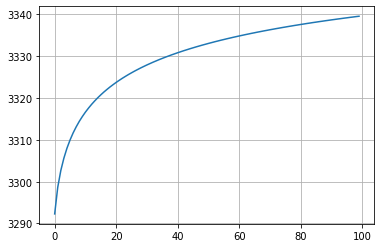

In [ ]:
learning_rate = jnp.array(5e-1)
epochs = 100
layer_size = 1

alphas = jnp.ones(features)
alphas_opt, losses = train_laplace(alphas, X_train, Y_train, learning_rate, epochs)

plt.grid()
plt.plot(losses)
plt.show()

DeviceArray([[5.6656137, 0.       , 0.       , ..., 0.       , 0.       ,
              0.       ],
             [0.       , 6.3512993, 0.       , ..., 0.       , 0.       ,
              0.       ],
             [0.       , 0.       , 5.9616876, ..., 0.       , 0.       ,
              0.       ],
             ...,
             [0.       , 0.       , 0.       , ..., 7.176712 , 0.       ,
              0.       ],
             [0.       , 0.       , 0.       , ..., 0.       , 3.9963732,
              0.       ],
             [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
              6.9613967]], dtype=float32)

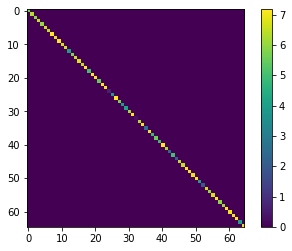

In [ ]:
plt.imshow(jnp.diag(alphas_opt))
plt.colorbar()
jnp.diag(alphas_opt)

### Covariance matrixes for several extremes

10it [05:15, 31.51s/it]


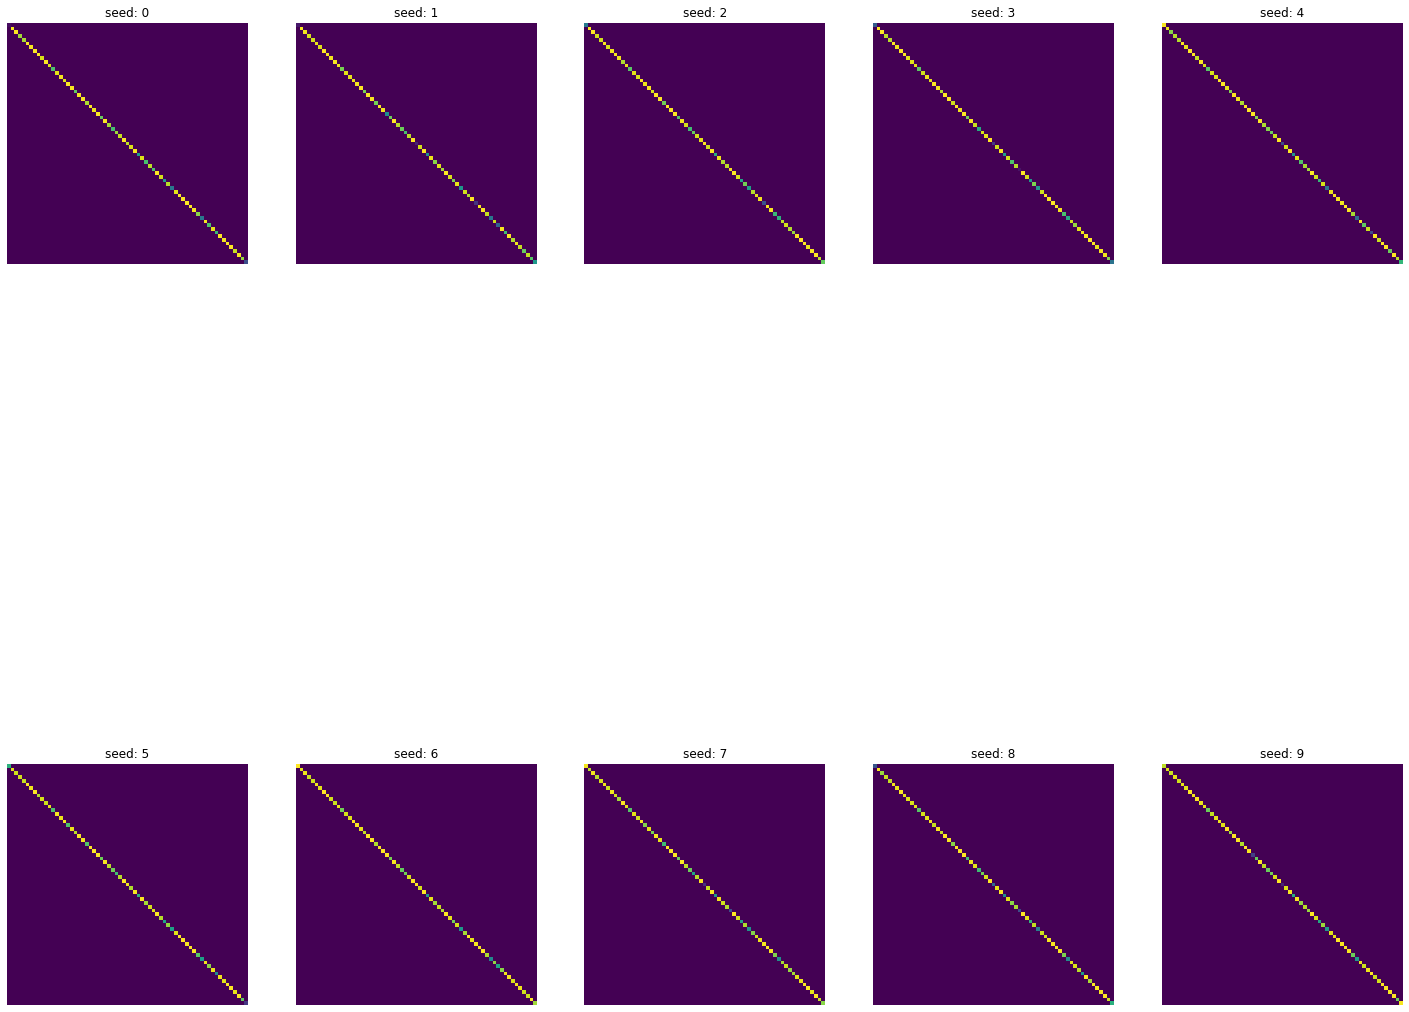

In [57]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(25, 25))
epochs = 100
layer_size = 1

for seed_id, ax in tqdm(zip(range(10), axs.ravel())):
    seed = random.PRNGKey(seed_id)

    weights = initialize_weights(layer_size, seed)
    alphas = jnp.ones(features)

    learning_rate = jnp.array(2e-4)
    weights_map, losses = train(weights, X_train, Y_train, learning_rate, epochs, verbose=False)
    learning_rate = jnp.array(1e-1)
    alphas_opt, losses = train_laplace(alphas, X_train, Y_train, learning_rate, epochs, verbose=False)

    ax.set_title(f'seed: {seed_id}')
    ax.imshow(jnp.diag(alphas_opt))
    ax.axis('off')